In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import jit, vmap
import jaxquantum as jqt
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

/home/shanj/miniconda3/envs/jax-new/lib/python3.12/site-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


# Time Independent

In [3]:
H_x = jqt.sigmax()
ts = jnp.linspace(0.0, 2*jnp.pi, 101)
U_props = jqt.propagator(H_x, ts)
U_props[-1] - jqt.propagator(H_x, ts[-1])

Quantum array: dims = [[2], [2]], shape = (2, 2), type = oper
Qarray data =
[[0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

# Time Dependent

In [4]:
omega_q = 5.0 #GHzz
Omega = .1
g_state = jqt.basis(2,0) ^ jqt.basis(2,0)
ts = jnp.linspace(0.0,5*jnp.pi/Omega,101)

sz0 = jqt.sigmaz() ^ jqt.identity(N=2)

@jit
def Ht(t):
    H0 = omega_q/2.0*((jqt.sigmaz()^jqt.identity(N=2)) + (jqt.identity(N=2)^jqt.sigmaz()))
    H1 = Omega*jnp.cos((omega_q)*t)*((jqt.sigmax()^jqt.identity(N=2)) + (jqt.identity(N=2)^jqt.sigmax()))
    return H0 + H1

In [5]:
# baseline to test against
states = jqt.sesolve(g_state, ts, Ht=Ht) 
szt = jnp.real(jqt.calc_expect(sz0, states))

100% |██████████| [00:00<00:00, 278.25%/s]


In [6]:
# fastest way to calculate propagators for many time points
solver_options = jqt.SolverOptions.create(progress_meter=False)
U_props = jqt.propagator(Ht, ts, solver_options=solver_options)
states_prop = [U_prop @ g_state for U_prop in U_props]
szt_prop = jnp.real(jqt.calc_expect(sz0, states_prop))

In [7]:
# testing propagators on scalar t, this is much slower
ts_2 = jnp.linspace(0.0, 5*jnp.pi/Omega, 11)
U_props = [jqt.propagator(Ht, t, solver_options=solver_options) for t in ts_2]
states_prop = [U_prop @ g_state for U_prop in U_props]
szt_prop2 = jnp.real(jqt.calc_expect(sz0, states_prop))

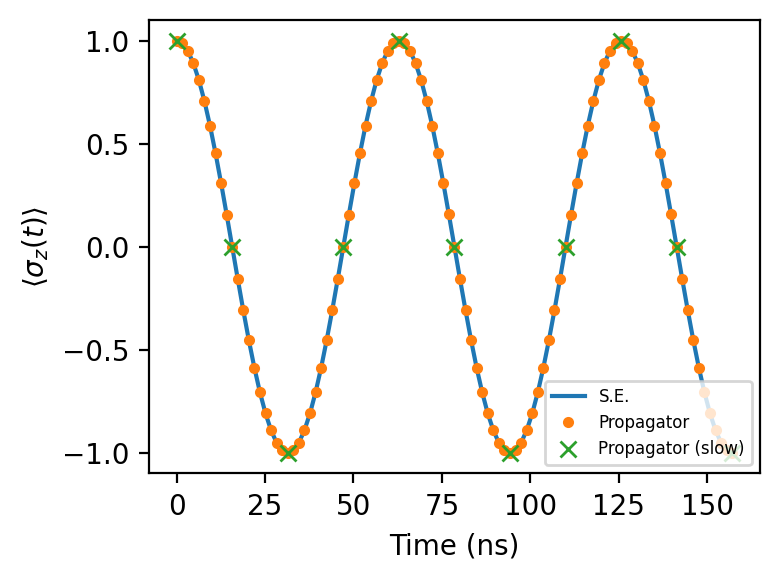

In [8]:
# plotting
fig, ax = plt.subplots(1, dpi=200, figsize=(4,3))
ax.plot(ts, szt, label="S.E.")
ax.plot(ts, szt, ".", label="Propagator")
ax.plot(ts_2, szt_prop2, "x", label="Propagator (slow)")
ax.legend(fontsize=6, loc="lower right")
ax.set_xlabel("Time (ns)")
ax.set_ylabel(r"$\langle\sigma_z(t)\rangle$")
fig.tight_layout()